# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

mlagents 0.4.0 has requirement protobuf<3.7,>=3.6, but you'll have protobuf 3.5.2 which is incompatible.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
import platform
 
print(platform.python_version())

3.6.6


In [3]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="Tennis_Linux_NoVis/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [6]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [7]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [8]:
import torch
from maddpg import MADDPG
from collections import deque
import matplotlib.pyplot as plt
import time
from utilities import transpose_list, transpose_to_tensor
import os
from replay_buffer import ReplayBuffer

%matplotlib inline

In [9]:
def marl_runner(brain_name, n_episode=1000, episode_length=500, noise=1, noise_reduction=0.9999, goal_score=0.5, is_train_mode=True):
    max_score_for_episode_across_agents = []
    scores_deque = deque(maxlen=100)
    min_scores = []
    max_scores = []
    moving_average = []
    
    buffer_length = int(100*episode_length)
    batchsize = 500
    buffer = ReplayBuffer(buffer_length, seed = 2)
    
    episode_per_update = 2
    save_every_x_episode = 10
    episodes_before_train = 0
    model_dir= os.getcwd()+"/model_dir"
    
    #Get the agent instance
    maddpg_agent = MADDPG(episodes_before_train=episodes_before_train, batch_size=batchsize, replay_buffer=buffer)
    agent0_reward = []
    agent1_reward = []
    
    #Training loop
    for episode_no in range (1, n_episode):
        maddpg_agent.reset()
        begin_time = time.time()
        score_current_episode = np.zeros(num_agents)
        
        env_info = env.reset(train_mode=is_train_mode)[brain_name]
        obs = env_info.vector_observations
        scores = np.zeros(num_agents)
        
        for episode_timestep in range(episode_length):
            actions = maddpg_agent.act(obs, noise=noise)
            noise *= noise_reduction
        
            env_info = env.step(actions)[brain_name]  
        
            next_obs = env_info.vector_observations

            rewards = env_info.rewards
            dones = env_info.local_done
            # add data to buffer
            maddpg_agent.step(episode_no, obs, actions, rewards, next_obs, dones)
            obs = next_obs
            score_current_episode += rewards
            
        agent0_reward.append(score_current_episode[0])
        agent1_reward.append(score_current_episode[1])
        
        max_score_for_episode_across_agents.append(np.max(score_current_episode))
        scores_deque.append(np.max(score_current_episode))
        moving_average.append(np.mean(max_score_for_episode_across_agents))
        mean_score_agents = np.mean(scores_deque)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode_no, mean_score_agents))
        
        if episode_no % 100 == save_every_x_episode or episode_no == n_episode - 1:
            save_dict_list = []
            for i in range(num_agents):
                save_dict = {'actor_params' : maddpg_agent.maddpg_agent[i].actor.state_dict(),
                             'actor_optim_params': maddpg_agent.maddpg_agent[i].actor_optimizer.state_dict(),
                             'critic_params' : maddpg_agent.maddpg_agent[i].critic.state_dict(),
                             'critic_optim_params' : maddpg_agent.maddpg_agent[i].critic_optimizer.state_dict()}
                save_dict_list.append(save_dict)

                torch.save(save_dict_list, os.path.join(model_dir, 'episode-{}.pth'.format(episode_no)))
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode_no, mean_score_agents))
            
        if mean_score_agents >= goal_score and episode_no >= 100:
            save_dict_list = []
            for i in range(num_agents):
                save_dict = {'actor_params' : maddpg_agent.maddpg_agent[i].actor.state_dict(),
                             'actor_optim_params': maddpg_agent.maddpg_agent[i].actor_optimizer.state_dict(),
                             'critic_params' : maddpg_agent.maddpg_agent[i].critic.state_dict(),
                             'critic_optim_params' : maddpg_agent.maddpg_agent[i].critic_optimizer.state_dict()}
                save_dict_list.append(save_dict)
            torch.save(save_dict_list, os.path.join(model_dir, 'episode-{}.pth'.format(episode_no)))
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode_no-100, mean_score_agents))
            break
            
    return max_score_for_episode_across_agents, moving_average

In [11]:
max_score_for_episode_across_agents, moving_average = marl_runner(brain_name)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 1	Average Score: -0.03
Episode 2	Average Score: -0.03
Episode 3	Average Score: 0.02
Episode 4	Average Score: 0.14
Episode 5	Average Score: 0.15
Episode 6	Average Score: 0.17
Episode 7	Average Score: 0.18
Episode 8	Average Score: 0.22
Episode 9	Average Score: 0.25
Episode 10	Average Score: 0.30
Episode 10	Average Score: 0.30
Episode 10	Average Score: 0.30
Episode 11	Average Score: 0.35
Episode 12	Average Score: 0.40
Episode 13	Average Score: 0.44
Episode 14	Average Score: 0.45
Episode 15	Average Score: 0.46
Episode 16	Average Score: 0.48
Episode 17	Average Score: 0.49
Episode 18	Average Score: 0.50
Episode 19	Average Score: 0.48
Episode 20	Average Score: 0.47
Episode 21	Average Score: 0.44
Episode 22	Average Score: 0.46
Episode 23	Average Score: 0.49
Episode 24	Average Score: 0.52
Episode 25	Average Score: 0.53
Episode 26	Average Score: 0.54
Episode 27	Average Score: 0.57
Episode 28	Average Score: 0.58
Episode 29	Average Score: 0.60
Episode 30	Average Score: 0.61
Episode 31	Aver

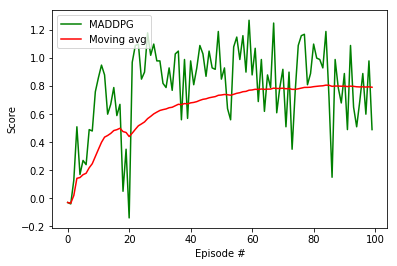

In [15]:
#Plot the scores
fig = plt.figure()
axes = fig.add_subplot(111)
plt.plot(np.arange(len(max_score_for_episode_across_agents)), max_score_for_episode_across_agents, c='g', label='MADDPG')
plt.plot(np.arange(len(max_score_for_episode_across_agents)), moving_average, c='r', label='Moving avg')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left')
plt.show()

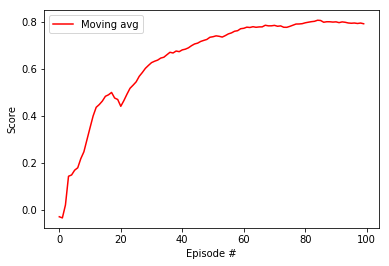

In [16]:
#Plot the moving average vs episodes
fig = plt.figure()
axes = fig.add_subplot(111)
plt.plot(np.arange(len(max_score_for_episode_across_agents)), moving_average, c='r', label='Moving avg')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left')
plt.show()